## Generate random data

In [51]:
import numpy as np

def generate_random_data(num_samples, seq_length, range_min, range_max):
	"""
	Generate random sequences for training
	"""
	data = np.random.randint(range_min, range_max, (num_samples, seq_length))
	return data

In [65]:
data = generate_random_data(10000, 8, 0, 2**16)
data

array([[11399, 23766, 11948, ...,  5738, 51141, 40272],
       [23238, 38795, 50247, ..., 31550,  6959, 61216],
       [ 7543, 49654, 21931, ...,  1703, 34236, 47708],
       ...,
       [64543, 55658, 36899, ..., 61831, 28841, 25483],
       [49146, 58685, 61480, ...,  8030, 51962, 16028],
       [13896, 24988, 58395, ..., 14359, 33370, 26083]])

## Normalize data

In [66]:
def normalize_data(data, range_min, range_max):
	"""
	Normalize data to the range [0,1]
	"""
	return (data - range_min) / (range_max - range_min)

In [67]:
data_norm = normalize_data(data, 0, 2**16)
data_norm

array([[0.17393494, 0.36264038, 0.18231201, ..., 0.08755493, 0.78034973,
        0.61450195],
       [0.35458374, 0.59196472, 0.76670837, ..., 0.48141479, 0.10618591,
        0.93408203],
       [0.11509705, 0.75765991, 0.3346405 , ..., 0.02598572, 0.5223999 ,
        0.72796631],
       ...,
       [0.98484802, 0.84927368, 0.56303406, ..., 0.94346619, 0.44007874,
        0.38883972],
       [0.74990845, 0.89546204, 0.93811035, ..., 0.12252808, 0.7928772 ,
        0.24456787],
       [0.21203613, 0.38128662, 0.89103699, ..., 0.21910095, 0.50918579,
        0.397995  ]])

## Visualize normalized data

In [68]:
import matplotlib.pyplot as plt

def plot_histogram(data, title):
	"""
	Plot histogram of the data to visulaize its distribution
	"""
	plt.hist(data.flatten(), bins=50, alpha=0.75, color='green')
	plt.title(title)
	plt.xlabel("Value")
	plt.ylabel("Frequency")
	plt.show()

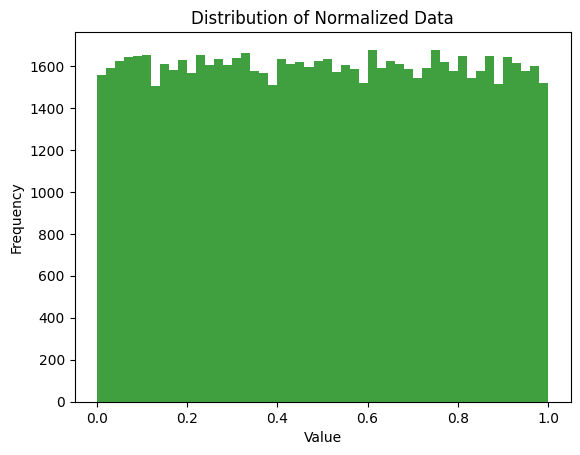

In [69]:
plot_histogram(data_norm, "Distribution of Normalized Data")

## Generator

In [70]:
import tensorflow as tf

def build_generator(input_dim):
	"""
	Builds the generator model
	Args:
		input_dim (int): Dimension of the input vector [seed + offset]
	Returns:
		tf.keras.Model: Generator model
	"""
	model = tf.keras.Sequential([
		tf.keras.layers.InputLayer(input_shape=(input_dim,)),  # Input Layer
		tf.keras.layers.Dense(30, activation=tf.keras.layers.LeakyReLU(0.2)),
		tf.keras.layers.Dense(30, activation=tf.keras.layers.LeakyReLU(0.2)),
		tf.keras.layers.Dense(30, activation=tf.keras.layers.LeakyReLU(0.2)),
		tf.keras.layers.Dense(8, activation=lambda x: tf.math.mod(x, 1.0))  # Constain outputs
	])
	return model

In [72]:
generator = build_generator(input_dim=2)
generator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 30)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,198 (8.59 KB)

 Trainable params: 2,198 (8.59 KB)

 Non-trainable params: 0 (0.00 B)

## Discriminator

In [73]:
def build_discriminator(input_dim):
	"""
	Builds the discriminator model.
	Args:
		input_dim (int): Dimension of the input sequence
	Returns:
		tf.keras.Model: Discrtiminator model
	"""
	model = tf.keras.Sequential([
		tf.keras.layers.InputLayer((input_dim, 1)),  # Input Layer (reshape for convolution)
		tf.keras.layers.Conv1D(4, kernel_size=2, strides=1, activation='relu'),
		tf.keras.layers.MaxPooling1D(pool_size=2),
		tf.keras.layers.Conv1D(4, kernel_size=2, strides=1, activation='relu'),
		tf.keras.layers.MaxPooling1D(pool_size=2),
		tf.keras.layers.Flatten(),  # Flatten before dense layers
		tf.keras.layers.Dense(4, activation='relu'),
		tf.keras.layers.Dense(1, activation='sigmoid')  # Output: Real (1) or Fake (0)
	])
	return model

In [74]:
discriminator = build_discriminator(input_dim=8)
discriminator.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 7, 4)           │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73 (292.00 B)

 Trainable params: 73 (292.00 B)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Generate a random input for the generator 
seed = tf.random.uniform((1, 1))  # Random seed
offset = tf.constant([[0.5]])  # Example offset
gen_input = tf.concat([seed, offset], axis=1)  # Combine seed and offset

In [76]:
# Generate fake data
fake_data = generator(gen_input)
print(f'Generated fake data: {fake_data.numpy()}')

Generated fake data: [[0.9579294  0.12914465 0.08705177 0.9898894  0.02857297 0.95449686
  0.9681391  0.916432  ]]


In [77]:
# Test discriminator with real and fake data 
real_data = tf.random.uniform((1, 8), 0, 1) # Real random data 
real_score = discriminator(tf.expand_dims(real_data, -1)) # Add channel for Conv1D 
fake_score = discriminator(tf.expand_dims(fake_data, -1)) 
print("Discriminator score for real data:", real_score.numpy()) 
print("Discriminator score for fake data:", fake_score.numpy())

Discriminator score for real data: [[0.51434505]]
Discriminator score for fake data: [[0.52526706]]


## Loss

In [78]:
# Binary cross-entropy loss for discriminator and generator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
	"""
	Discriminator loss to classify real as 1 and fake as 0
	"""
	real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real -> 1
	fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake -> 0
	return real_loss + fake_loss

def generator_loss(fake_output):
	"""
	Generator loss to fool the discriminator (fake -> 1)
	"""
	return cross_entropy(tf.ones_like(fake_output), fake_output)  # Fake -> 1

## Optimzers

In [79]:
# Learning rates for generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

## Testing Loss function

In [80]:
# Example real and fake outputs from discriminator
real_output = tf.constant([[0.8], [0.9]])   # Discriminator thinks real is likely real
fake_output = tf.constant([[0.3], [0.2]])   # Discriminator thinks fake is likely fake

# Calculate losses
d_loss = discriminator_loss(real_output, fake_output)
g_loss = generator_loss(fake_output)

print(f'Discriminator Loss: {d_loss.numpy()}')
print(f'Generator Loss: {g_loss.numpy()}')

Discriminator Loss: 0.45416128635406494
Generator Loss: 1.406705379486084


## Training Loop

In [81]:
import tensorflow as tf
import numpy as np

@tf.function
def train_step(real_data, generator, discriminator, generator_optimizer, discriminator_optimizer):
    """
    Performs a single training step for both generator and discriminator.
    """
    # Generate random seed and offset for the generator
    seed = tf.random.uniform((real_data.shape[0], 1), minval=0, maxval=1)
    offset = tf.random.uniform((real_data.shape[0], 1), minval=0, maxval=1)
    gen_input = tf.concat([seed, offset], axis=1)

    # Gradient updates for the discriminator
    with tf.GradientTape() as disc_tape:
        fake_data = generator(gen_input, training=True)
        real_output = discriminator(tf.expand_dims(real_data, -1), training=True)
        fake_output = discriminator(tf.expand_dims(fake_data, -1), training=True)
        d_loss = discriminator_loss(real_output, fake_output)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Gradient updates for the generator
    with tf.GradientTape() as gen_tape:
        fake_data = generator(gen_input, training=True)
        fake_output = discriminator(tf.expand_dims(fake_data, -1), training=True)
        g_loss = generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return d_loss, g_loss


In [82]:
def train_gan(generator, discriminator, data, generator_optimizer, discriminator_optimizer, epochs, batch_size):
    """
    Trains the GAN for a specified number of epochs.
    """
    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1024).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for real_data in dataset:
            d_loss, g_loss = train_step(real_data, generator, discriminator, generator_optimizer, discriminator_optimizer)

        print(f"Discriminator Loss: {d_loss.numpy()}, Generator Loss: {g_loss.numpy()}")

In [83]:
# Generate normalized random data
random_data = generate_random_data(10000, 8, 0, 2**16)
normalized_data = normalize_data(random_data, 0, 2**16)

In [88]:
# Train the GAN
train_gan(
    generator,
    discriminator,
    normalized_data,
    generator_optimizer,
    discriminator_optimizer,
    epochs=100,  # Adjust as needed
    batch_size=64
)

Epoch 1/100
Discriminator Loss: 0.032715629786252975, Generator Loss: 5.269298553466797
Epoch 2/100
Discriminator Loss: 0.06605032831430435, Generator Loss: 4.906110763549805
Epoch 3/100
Discriminator Loss: 0.006558879278600216, Generator Loss: 5.421892166137695
Epoch 4/100
Discriminator Loss: 0.005610071122646332, Generator Loss: 5.504515647888184
Epoch 5/100
Discriminator Loss: 0.026425324380397797, Generator Loss: 5.392353057861328
Epoch 6/100
Discriminator Loss: 0.004877495113760233, Generator Loss: 5.635478496551514
Epoch 7/100
Discriminator Loss: 0.007140283472836018, Generator Loss: 5.744602203369141
Epoch 8/100
Discriminator Loss: 0.00587331410497427, Generator Loss: 5.639960289001465
Epoch 9/100
Discriminator Loss: 0.00469434168189764, Generator Loss: 5.717818260192871
Epoch 10/100
Discriminator Loss: 0.028806110844016075, Generator Loss: 5.4617486000061035
Epoch 11/100
Discriminator Loss: 0.003865031059831381, Generator Loss: 5.798145771026611
Epoch 12/100
Discriminator Loss:

2025-01-01 23:29:20.156042: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Discriminator Loss: 0.0009930582018569112, Generator Loss: 6.920587539672852
Epoch 29/100
Discriminator Loss: 0.000946001906413585, Generator Loss: 7.003106117248535
Epoch 30/100
Discriminator Loss: 0.0008574592065997422, Generator Loss: 7.067185878753662
Epoch 31/100
Discriminator Loss: 0.0008034845814108849, Generator Loss: 7.137770652770996
Epoch 32/100
Discriminator Loss: 0.0007556327618658543, Generator Loss: 7.202399730682373
Epoch 33/100
Discriminator Loss: 0.0006960683385841548, Generator Loss: 7.275539398193359
Epoch 34/100
Discriminator Loss: 0.0007155784405767918, Generator Loss: 7.3439717292785645
Epoch 35/100
Discriminator Loss: 0.0006090663373470306, Generator Loss: 7.410736560821533
Epoch 36/100
Discriminator Loss: 0.0005688312230631709, Generator Loss: 7.475977897644043
Epoch 37/100
Discriminator Loss: 0.0005367432022467256, Generator Loss: 7.5347700119018555
Epoch 38/100
Discriminator Loss: 0.0006854858947917819, Generator Loss: 7.598392009735107
Epoch 39/100
Discrimin

## Evaluate

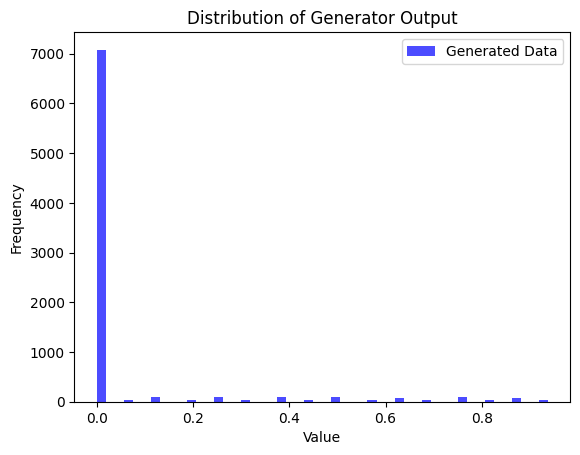

In [89]:
# Generate random inputs for the generator
num_samples = 1000
seed = tf.random.uniform((num_samples, 1), minval=0, maxval=1)
offset = tf.random.uniform((num_samples, 1), minval=0, maxval=1)
gen_input = tf.concat([seed, offset], axis=1)

# Generate fake data
fake_data = generator(gen_input, training=False)

# Visualize the output
import matplotlib.pyplot as plt

plt.hist(fake_data.numpy().flatten(), bins=50, alpha=0.7, color='blue', label='Generated Data')
plt.title("Distribution of Generator Output")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Validate randomness

In [90]:
# Compute basic statistics
mean = tf.reduce_mean(fake_data).numpy()
variance = tf.math.reduce_variance(fake_data).numpy()
print(f"Mean of generated data: {mean}")
print(f"Variance of generated data: {variance}")

# Perform a Kolmogorov-Smirnov (KS) test for uniformity
from scipy.stats import kstest

flat_data = fake_data.numpy().flatten()
ks_stat, ks_p_value = kstest(flat_data, 'uniform', args=(0, 1))  # Check against uniform distribution
print(f"KS Statistic: {ks_stat}, P-value: {ks_p_value}")

if ks_p_value > 0.05:
    print("Generated data appears to be uniformly distributed (p > 0.05).")
else:
    print("Generated data does not appear uniformly distributed (p <= 0.05).")

Mean of generated data: 0.05655859410762787
Variance of generated data: 0.03252292051911354
KS Statistic: 0.885125, P-value: 0.0
Generated data does not appear uniformly distributed (p <= 0.05).


## Converts Output -> Binary

In [87]:
# Convert generated data to binary (16-bit integers)
def float_to_binary(data, bit_length=16):
    """
    Converts normalized float data to binary representation.
    """
    int_data = (data.numpy() * (2**bit_length - 1)).astype(int)
    binary_data = ''.join(f"{x:016b}" for x in int_data.flatten())
    return binary_data

binary_data = float_to_binary(fake_data)
with open("generated_data.bin", "w") as f:
    f.write(binary_data)
print("Binary data saved to 'generated_data.bin'")

Binary data saved to 'generated_data.bin'
